### Generate plots of firing rates, rasters of RPE and Feature selective units
- Example RPE selective unit: 20180803, unit 17 (PFC)
- Example Pattern selective unit: 2018072500001 unit 12 (HC)
- Example Combined unit: 20180803, unit 30


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.behavioral_utils as behavioral_utils
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

import os
import pandas as pd
import matplotlib

In [2]:
SUBJECT = "SA"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"

PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "FeedbackOnset"

FEATURE_DIMS = ["Color", "Shape", "Pattern"]

In [3]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
units = spike_utils.get_unit_positions(valid_sess)

In [4]:
def get_data(session):
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber")
    valid_beh_rpes = behavioral_utils.get_rpe_groups_per_session(session, valid_beh)
    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
    frs = pd.read_pickle(fr_path)

    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)

    spike_times = spike_general.get_spike_times(None, SUBJECT, session, species_dir="/data")
    intervals = behavioral_utils.get_trial_intervals(valid_beh, EVENT, PRE_INTERVAL, POST_INTERVAL)
    spike_by_trial_interval = spike_utils.get_spikes_by_trial_interval(spike_times, intervals)
    spike_by_trial_interval.TrialNumber = spike_by_trial_interval.TrialNumber.astype(int)
    return frs, spike_by_trial_interval, valid_beh_rpes, pos

In [5]:
def plot_raster(unit, spike_times, beh, group_name, group_colors, group_ordering, ax):
    group_offset = 0
    unit_spikes = spike_times[spike_times.UnitID == unit]
    for group in group_ordering:
        group_beh = beh[beh[group_name] == group]
        group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
        group_offset += len(group_beh)
        spikes = pd.merge(unit_spikes, group_beh, on="TrialNumber")
        spikes["X"] = (spikes.SpikeTimeFromStart - PRE_INTERVAL) / 1000
        ax.scatter(spikes.X, spikes.Y, marker="_", linewidths=1, label=group, s=1, color=group_colors[group])

### Look at RPE selective first

In [6]:
session = "20180803"
unit = 17
frs, spike_times, beh, pos = get_data(session)

In [9]:
# test code, delete later
from scipy.ndimage import gaussian_filter1d

def smooth_unit_fr(unit_group):
    unit_sorted = unit_group.sort_values(by="TimeBins")
    unit_sorted["FiringRate"] = gaussian_filter1d(unit_sorted.SpikeCounts, 1)
    return unit_sorted
frs.groupby(["UnitID", "TrialNumber"]).apply(smooth_unit_fr)

/tmp/ipykernel_496286/520537595.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  frs.groupby(["UnitID", "TrialNumber"]).apply(smooth_unit_fr)


,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate
0,0,0,0.00,0.0,0.058423
1,0,0,0.05,0.0,0.242105
2,0,0,0.10,1.0,0.398943
3,0,0,0.15,0.0,0.241971
4,0,0,0.20,0.0,0.054125
...,...,...,...,...,...
3614403,1508,42,2.55,0.0,0.000000
3614404,1508,42,2.60,0.0,0.000000
3614405,1508,42,2.65,0.0,0.000000
3614406,1508,42,2.70,0.0,0.000000


In [9]:
pos[pos.UnitID == 17]

,Channel,Unit,SpikeTimesFile,UnitID,electrode_id,x,y,z,distance,in_brain,...,structure_level1,structure_level2,structure_level3,structure_level4,structure_level5,structure_level6,structure_potential,session,PseudoUnitID,manual_structure
17,22a,1,/data/rawdata/sub-SA/sess-20180803/spikes/sub-...,17,22a,2.914448,-73.851514,41.676919,8.125,True,...,Frontal_Lobe (Frontal),lateral_prefrontal_cortex (lat_PFC),ventrolateral_prefrontal_cortex (vlPFC),rostral_ventrolateral_prefrontal_cortex (rostr...,ventral_and_fundus_portion_of_area_46 (area_46...,area_46_in_fundus_of_the_principal_sulcus (are...,[],20180803,2018080317,Prefrontal Cortex


/tmp/ipykernel_2583183/1513157827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
/tmp/ipykernel_2583183/1513157827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
/tmp/ipykernel_2583183/1513157827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

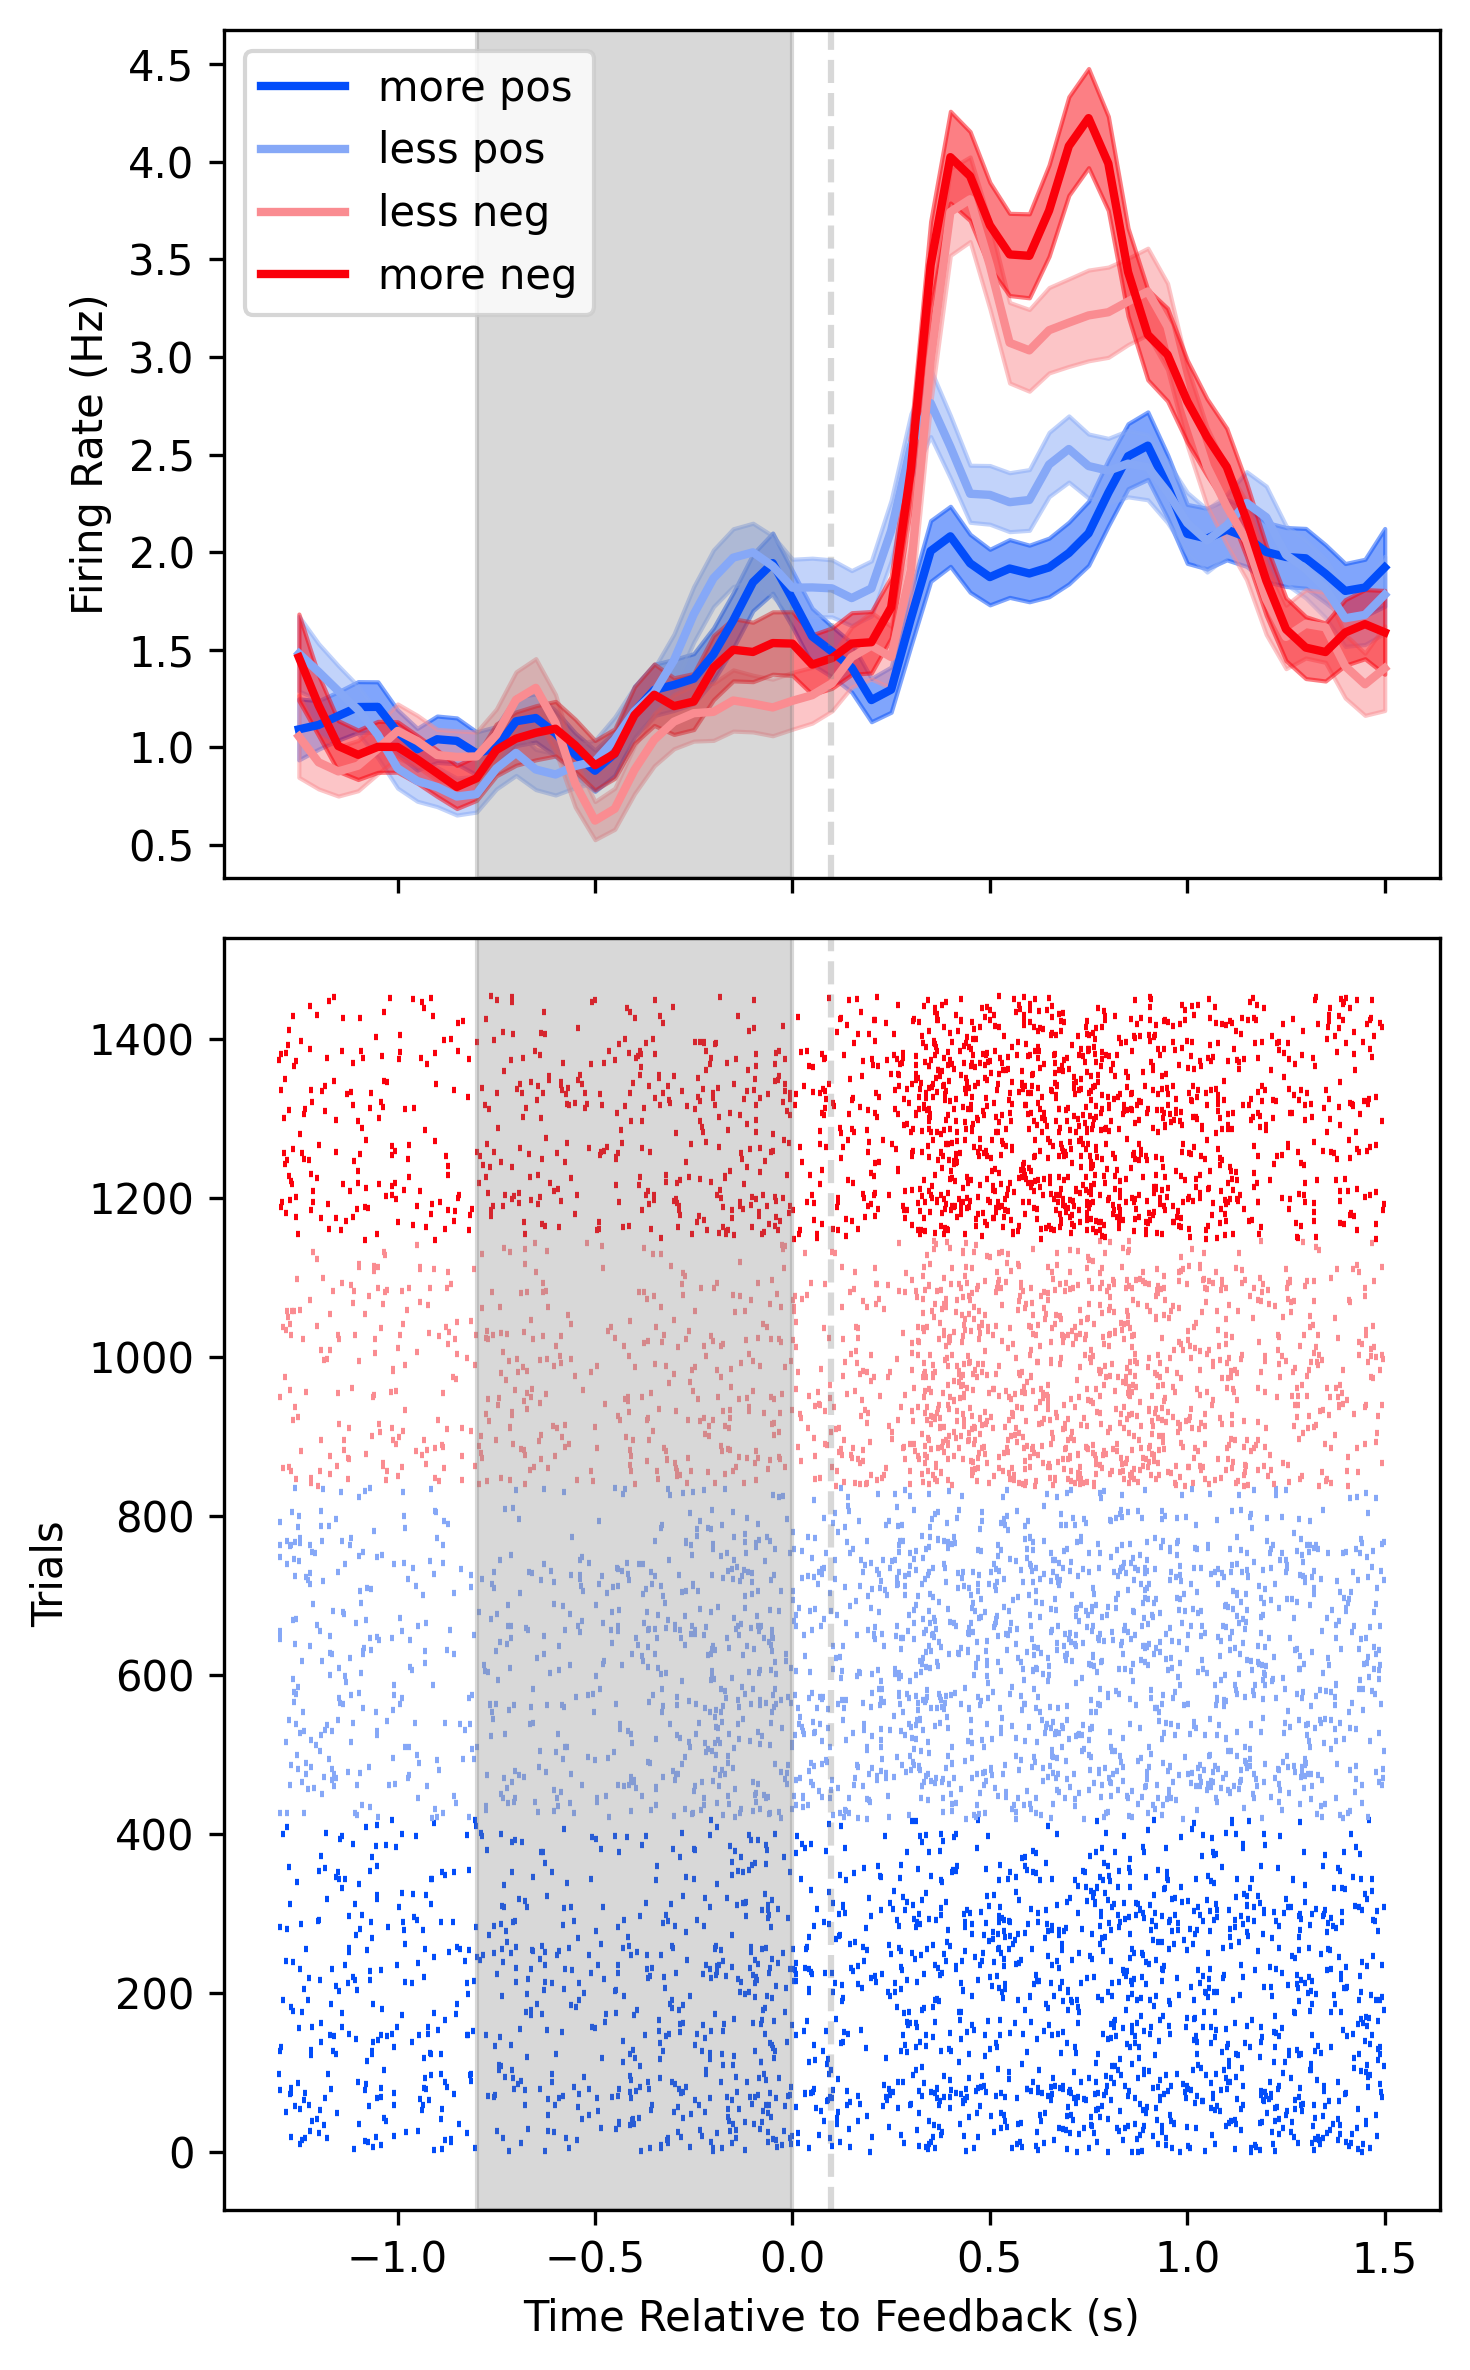

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(5, 8), gridspec_kw={'height_ratios': [4, 6]}, sharex=True, dpi=300)
group_name = "RPEGroup"
group_colors = {
    "more pos": "#024dfa",
    "less pos": "#86a8f7",
    "less neg": "#fa8c91",
    "more neg": "#fa000b",
}
group_ordering = ["more pos", "less pos", "less neg", "more neg"]
ax = axs[0]
visualization_utils.plot_mean_frs_by_group(
    session, unit, frs, beh, group_name, pos, ax, 
    mode="FiringRate", group_colors=group_colors, group_order=group_ordering, set_ax=False
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_ylabel("Firing Rate (Hz)")
ax = axs[1]
plot_raster(unit, spike_times, beh, group_name, group_colors, group_ordering, ax)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')        
ax.set_ylabel("Trials")
ax.set_xlabel("Time Relative to Feedback (s)")
fig.tight_layout()


### Now do Pattern selective neuron

In [15]:
session = "201807250001"
unit = 12
frs, spike_times, beh, pos = get_data(session)

/tmp/ipykernel_2583183/1291780506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
/tmp/ipykernel_2583183/1291780506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
/tmp/ipykernel_2583183/1291780506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

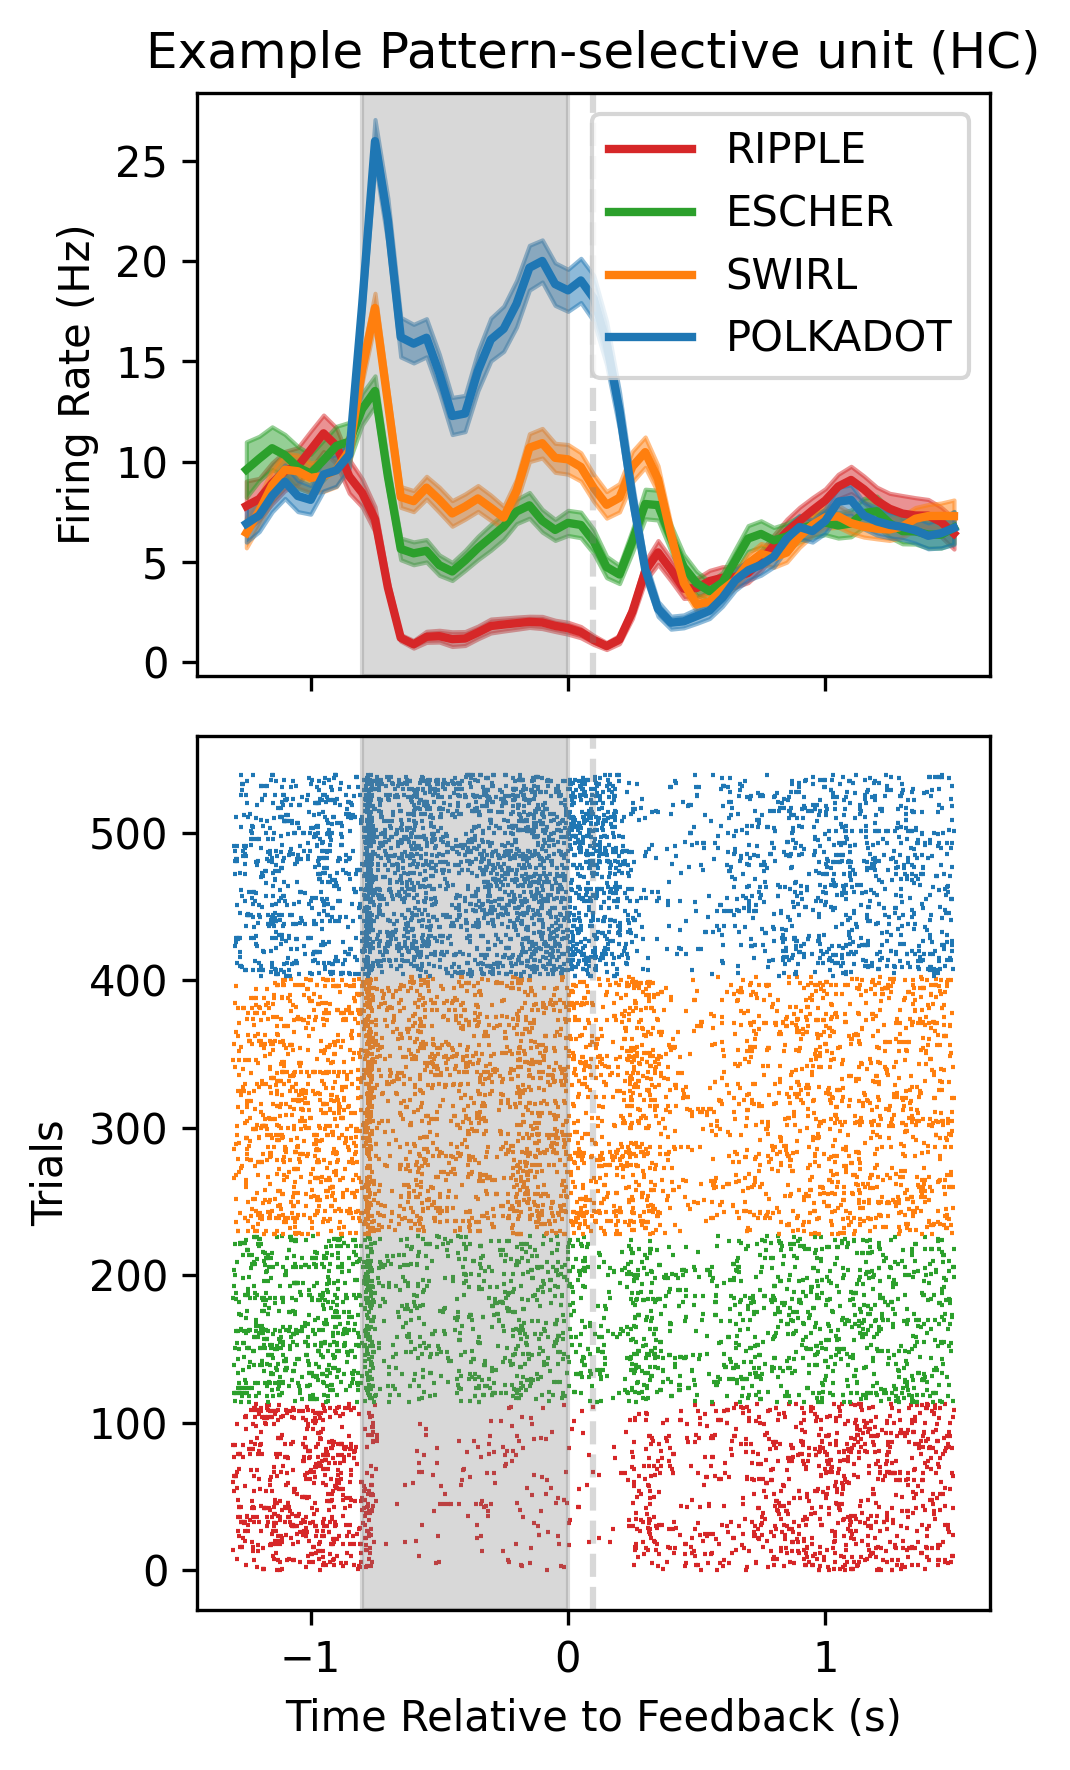

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 6), gridspec_kw={'height_ratios': [2, 3]}, sharex=True, dpi=300)
plt.rcParams.update({'font.size': 10})
group_name = "Pattern"
group_colors = {
    "POLKADOT": "tab:blue", 
    "SWIRL": "tab:orange", 
    "ESCHER": "tab:green", 
    "RIPPLE": "tab:red"
}
# group_ordering = ["POLKADOT", "SWIRL", "ESCHER", "RIPPLE"]
group_ordering = ["RIPPLE", "ESCHER", "SWIRL", "POLKADOT"]

ax = axs[0]
visualization_utils.plot_mean_frs_by_group(
    session, unit, frs, beh, group_name, pos, ax, 
    mode="FiringRate", group_colors=group_colors, group_order=group_ordering, set_ax=False
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_ylabel("Firing Rate (Hz)")
ax.set_title("Example Pattern-selective unit (HC)")
ax = axs[1]
plot_raster(unit, spike_times, beh, group_name, group_colors, group_ordering, ax)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')        
ax.set_ylabel("Trials")
ax.set_xlabel("Time Relative to Feedback (s)")
fig.tight_layout()
fig.savefig("/data/patrick_res/figures/feature_example.svg", format="svg")


### Combined selective unit

/tmp/ipykernel_2530577/1513157827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
/tmp/ipykernel_2530577/1513157827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
/tmp/ipykernel_2530577/1513157827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

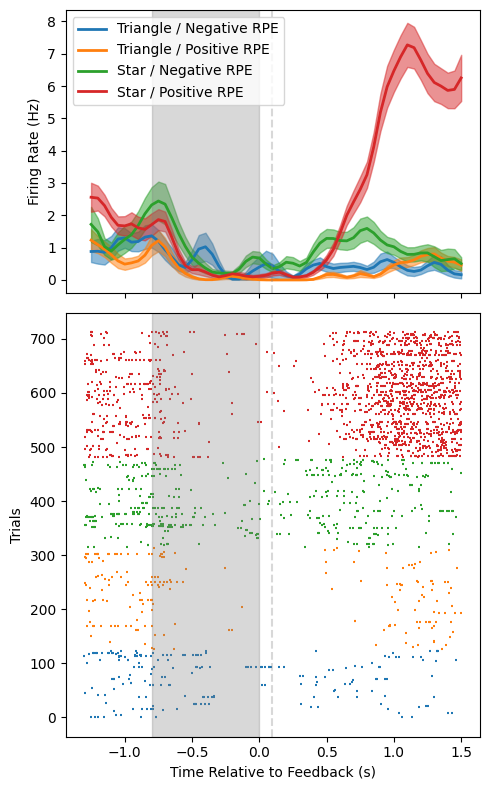

In [10]:
session = "20180803"
unit = 30
frs, spike_times, beh, pos = get_data(session)
beh["combined"] = beh["Shape"] + " " + beh["Response"]
# sub_beh = valid_beh[valid_beh.Shape.isin(["STAR", "TRIANGLE"]) & valid_beh.RPEGroup.isin(["more pos", "less pos"])]
beh = beh[beh.Shape.isin(["STAR", "TRIANGLE"])]
group_label = {
    "TRIANGLE Incorrect": "Triangle / Negative RPE",
    "TRIANGLE Correct": "Triangle / Positive RPE",
    "STAR Incorrect": "Star / Negative RPE",
    "STAR Correct": "Star / Positive RPE",
}
group_colors = {
    "TRIANGLE Incorrect": "tab:blue", 
    "TRIANGLE Correct": "tab:orange", 
    "STAR Incorrect": "tab:green", 
    "STAR Correct": "tab:red"
}
group_name = "combined"
group_ordering = ["TRIANGLE Incorrect", "TRIANGLE Correct", "STAR Incorrect", "STAR Correct"]

fig, axs = plt.subplots(2, 1, figsize=(5, 8), gridspec_kw={'height_ratios': [4, 6]}, sharex=True)
# group_ordering = ["POLKADOT", "SWIRL", "ESCHER", "RIPPLE"]

ax = axs[0]
visualization_utils.plot_mean_frs_by_group(
    session, unit, frs, beh, group_name, pos, ax, 
    mode="FiringRate", group_colors=group_colors, group_label=group_label,
    group_order=group_ordering, set_ax=False
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_ylabel("Firing Rate (Hz)")
ax = axs[1]
plot_raster(unit, spike_times, beh, group_name, group_colors, group_ordering, ax)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')        
ax.set_ylabel("Trials")
ax.set_xlabel("Time Relative to Feedback (s)")
fig.tight_layout()